# A Neural Network Trick for Ranking Problems

Code and plots for my corresponding [blog post](http://rhsimplex.github.io/2022/06/10/margin-ranking/). 

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Linear, CrossEntropyLoss, BCEWithLogitsLoss, L1Loss, MarginRankingLoss
from torch import sigmoid, relu, softmax
from torch.optim import SGD, Adam
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/winequality-red.csv')
df.quality -= 3
df['thresholded_quality'] = (df.quality >= 4).astype(int)

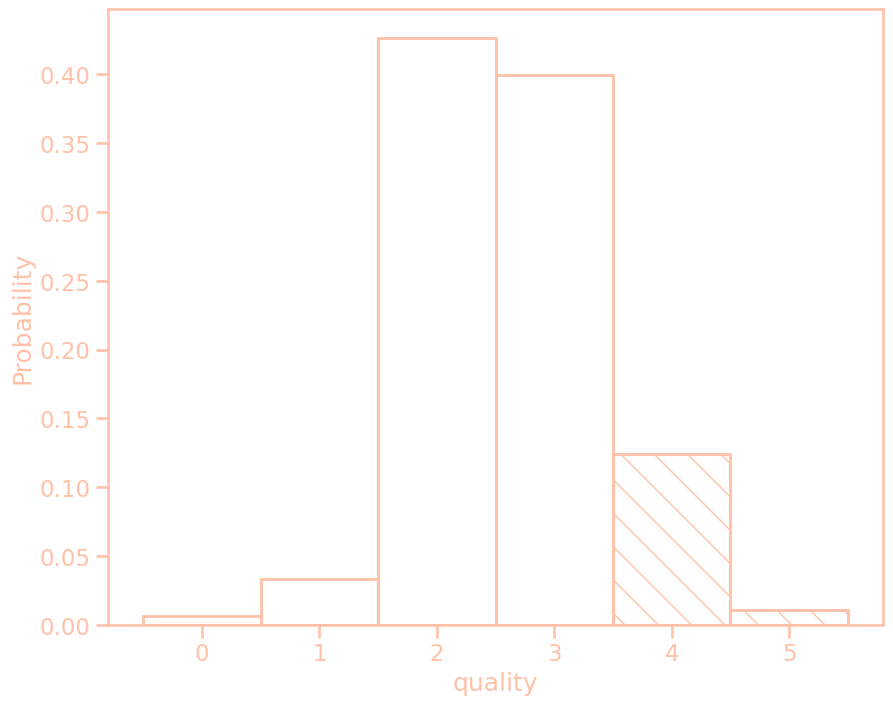

In [3]:
plt.figure(figsize=(10, 8))
text_color = '#ffc1a8'
sns.set_style("ticks")
sns.set_context("talk")
plt.rcParams['hatch.color'] = text_color
hist = sns.histplot(df, x='quality', discrete=True, stat='probability', legend=False, edgecolor=text_color, linewidth=2);

# Loop over the bars
for i,thisbar in enumerate(hist.patches):
    # Set a different hatch for each bar
    thisbar.fill = False
    if i == 4 or i == 5:
        thisbar.set_hatch('\\')
hist.tick_params(axis='x', colors=text_color)
hist.tick_params(axis='y', colors=text_color)
hist.spines['bottom'].set_color(text_color)
hist.spines['top'].set_color(text_color)
hist.spines['right'].set_color(text_color)
hist.spines['left'].set_color(text_color)
hist.yaxis.label.set_color(text_color)
hist.xaxis.label.set_color(text_color)
plt.savefig('./data/wine_quality_hist.svg', transparent=True, bbox_inches='tight')

In [4]:
skf = StratifiedKFold(5)
splits = []
for train_index, val_index in skf.split(X=df[df.columns[:-2]], y=df.quality):
    splits.append({'train': train_index, 'val': val_index})

In [5]:
class WineDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.df = self.df.astype('float32')
        self.input_columns = [col for col in self.df.columns if 'quality' not in col]
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.df.iloc[idx][self.input_columns].values, self.df.iloc[idx]['quality'], self.df.iloc[idx]['thresholded_quality']

In [6]:
class Model(Module):
    """A small network architecture with two hidden layers"""
    def __init__(self):
        super().__init__()
        self.layer_0 = Linear(in_features=11, out_features=10)
        self.layer_1 = Linear(in_features=10, out_features=10)

    def forward(self, x):
        x = sigmoid(self.layer_0(x))
        x = sigmoid(self.layer_1(x))
        return x

    def reset(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

class ModelMulticlass(Model):
    """With multiclass output"""
    def __init__(self):
        super().__init__()
        self.layer_out = Linear(in_features=10, out_features=6)

    def forward(self, x):
        x = super().forward(x)
        return self.layer_out(x)

class ModelSingleOutput(Model):
    """With a single output"""
    def __init__(self):
        super().__init__()
        self.layer_out = Linear(in_features=10, out_features=1)

    def forward(self, x):
        x = super().forward(x)
        return self.layer_out(x)

In [7]:
# Instantiate our models
model_regression = ModelSingleOutput()
model_multiclass = ModelMulticlass()
model_thr_class = ModelSingleOutput()
model_mrr = ModelSingleOutput()

In [8]:
class CombinedRankingLoss(BCEWithLogitsLoss):
    """Combine margin ranking loss with binary cross entropy loss

    This is the same as the version in the blog post, but slightly compressed and with some logging

    """
    def __init__(self, margin=0.0, mr_weight=1.0):
        super().__init__()
        self.mr_loss = MarginRankingLoss(margin=margin)
        self.mr_weight = mr_weight
        self._l = []
        self._mrr = []

    def __call__(self, outputs, y, y_threshold):
        _y = -torch.combinations(y).diff(dim=1).sign().squeeze()
        _outputs = torch.combinations(outputs.squeeze(-1))
        mrrl = self.mr_weight * self.mr_loss(_outputs[:, 0], _outputs[:, 1], _y)
        bce_loss = super().__call__(outputs, y_threshold)
        self._l.append(bce_loss.detach().numpy().item())
        self._mrr.append(mrrl.detach().numpy().item())
        return bce_loss + mrrl

In [9]:
def train(model, loss_fn, train_dataloader, val_dataloader, max_epochs=20):
    """A training loop for our models

    Returns: best ROCAUC score from all validation epochs
    """
    best_validation_ROC = 0.0
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            x, y_quality, y_thresholded_quality = data
            optimzer.zero_grad()
            outputs = model(x)
            if outputs.shape != y_quality.shape:
                outputs = torch.squeeze(outputs)
            if type(loss_fn) in [CrossEntropyLoss]:
                y = y_quality.long()
            elif type(loss_fn) in [BCEWithLogitsLoss]:
                y = y_thresholded_quality
            else:
                y = y_quality
            if type(loss_fn) is CombinedRankingLoss:
                loss = loss_fn(outputs, y_quality, y_thresholded_quality)
            else:
                loss = loss_fn(outputs, y)
            loss.backward()
            optimzer.step()

        with torch.no_grad():
            outputs = []
            labels = []
            for data in val_dataloader:
                x, _, y_thresholded_quality = data
                output = model(x)
                outputs.append(output)
                labels.append(y_thresholded_quality)
            outputs = torch.cat(outputs, 0)

            y = torch.cat(labels)
            if type(model) is ModelMulticlass:
                outputs = (softmax(outputs, dim=1)[:, 4:]).sum(axis=1)
            thr_rocauc = roc_auc_score(
                y.detach().numpy(),
                outputs.detach().numpy(),
            )
            if thr_rocauc > best_validation_ROC:
                best_validation_ROC = thr_rocauc
    return best_validation_ROC

In [10]:
# Cross-fold validation for Multi-class model

cross_entropy_fold_best = {}

for i in tqdm(range(skf.n_splits)):
    train_dataset = WineDataset(df.iloc[splits[i]['train']])
    val_dataset = WineDataset(df.iloc[splits[i]['val']])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

    model_multiclass.reset()
    optimzer = Adam(model_multiclass.parameters(), lr=0.01)
    loss_fn = CrossEntropyLoss()

    cross_entropy_fold_best[i] = train(model_multiclass, loss_fn, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:54<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Cross-fold validation for Single-class model

bce_thr_fold_best = {}

for i in tqdm(range(skf.n_splits)):
    train_dataset = WineDataset(df.iloc[splits[i]['train']])
    val_dataset = WineDataset(df.iloc[splits[i]['val']])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

    model_thr_class.reset()
    optimzer = Adam(model_thr_class.parameters(), lr=0.01)
    loss_fn = BCEWithLogitsLoss()

    bce_thr_fold_best[i] = train(model_thr_class, loss_fn, train_dataloader, val_dataloader)

100%|██████████| 5/5 [01:56<00:00, 23.36s/it]


In [ ]:
# Cross-fold validation for Regression model

reg_fold_best = {}

for i in tqdm(range(skf.n_splits)):
    train_dataset = WineDataset(df.iloc[splits[i]['train']])
    val_dataset = WineDataset(df.iloc[splits[i]['val']])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

    model_regression.reset()
    optimzer = Adam(model_regression.parameters(), lr=0.01)
    loss_fn = L1Loss()

    reg_fold_best[i] = train(model_regression, loss_fn, train_dataloader, val_dataloader)

100%|██████████| 5/5 [01:56<00:00, 23.40s/it]


In [ ]:
# Cross-fold validation for Single-class with ranking model

mr_fold_best = {}

for i in tqdm(range(skf.n_splits)):
    train_dataset = WineDataset(df.iloc[splits[i]['train']])
    val_dataset = WineDataset(df.iloc[splits[i]['val']])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

    model_mrr.reset()
    optimzer = Adam(model_mrr.parameters(), lr=0.01)
    mr_loss = CombinedRankingLoss(margin=1.0)

    mr_fold_best[i] = train(model_mrr, mr_loss, train_dataloader, val_dataloader)

100%|██████████| 5/5 [01:58<00:00, 23.75s/it]


In [14]:
results = pd.DataFrame(
    {
        'Regression': reg_fold_best,
        'Multi-class': cross_entropy_fold_best,
        'Single-class': bce_thr_fold_best,
        'Single-class with ranking': mr_fold_best,
    }
)

In [15]:
results = results.stack().reset_index().rename(columns={'level_0': 'Fold', 'level_1': 'Model', 0: 'ROCAUC'})

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('None').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725)) for an unfilled marker ('None').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('None').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.

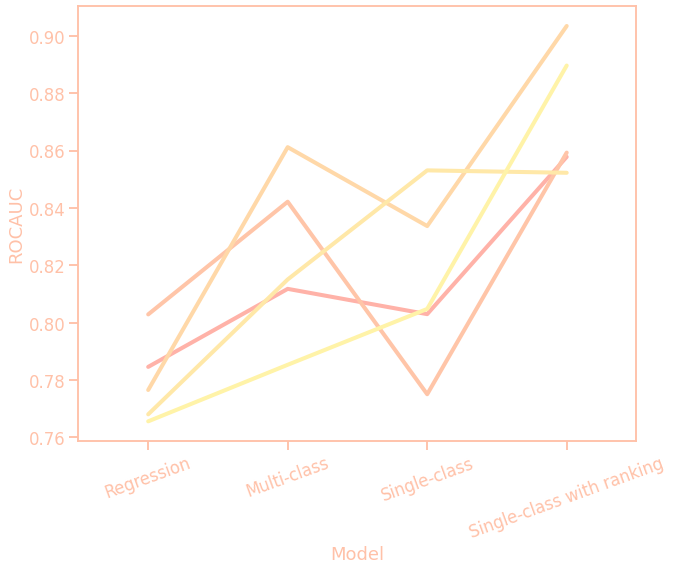

In [ ]:
plt.figure(figsize=(10, 8))
text_color = '#ffc1a8'
sns.set_style("ticks")
sns.set_context('talk');
ax = sns.pointplot(data=results, x='Model', y='ROCAUC', aspect=3.5, kind='line', hue='Fold', legend=False, markers='None')
ax.tick_params(axis='x', colors=text_color, rotation=20)
ax.tick_params(axis='y', colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['top'].set_color(text_color)
ax.spines['right'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.yaxis.label.set_color(text_color)
ax.xaxis.label.set_color(text_color)
ax.get_legend().remove()
if results.ROCAUC.min() < 0.5:
    ax.set_ylim([0.5, None])
styles = ['-', '--', '-.', ':', ' ']
for i, line in enumerate(ax.lines):

    if i < 5:
        line.set_color('#ffb2a8')
    elif i < 10:
        line.set_color('#ffc5a8')
    elif i < 15:
        line.set_color('#ffd8a8')
    elif i < 20:
        line.set_color('#ffe8a8')
    elif i < 25:
        line.set_color('#fff3a8')
plt.savefig('/kaggle/working/wine_model_comparison.svg', transparent=True, bbox_inches='tight')

In [ ]:
mr_margins = {}

for margin in [-1.0, 0.0, 1.0]:
    train_dataset = WineDataset(df.iloc[splits[0]['train']])
    val_dataset = WineDataset(df.iloc[splits[0]['val']])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

    model_mrr.reset()
    optimzer = Adam(model_mrr.parameters(), lr=0.01)
    mr_loss = CombinedRankingLoss(margin=margin)

    train(model_mrr, mr_loss, train_dataloader, val_dataloader);
    mr_margins[margin] = mr_loss._mrr.copy()

<Figure size 720x576 with 0 Axes>

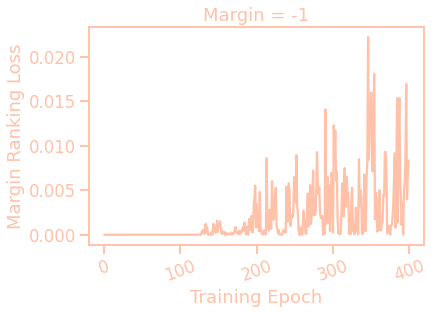

<Figure size 720x576 with 0 Axes>

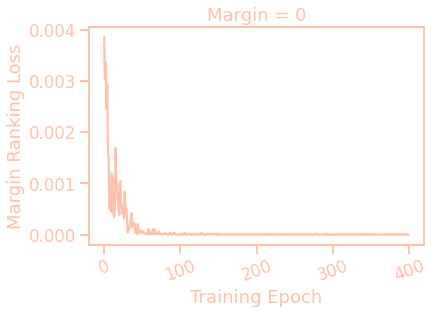

<Figure size 720x576 with 0 Axes>

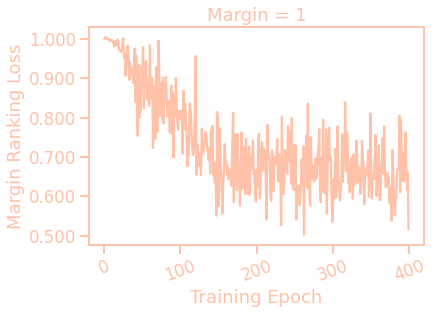

In [ ]:
from matplotlib import ticker
for margin in [-1, 0 ,1]:
    plt.figure(figsize=(10, 8));
    ax = pd.DataFrame(mr_margins[margin]).plot(color=text_color);
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'));
    ax.tick_params(axis='x', colors=text_color, rotation=20);
    ax.tick_params(axis='y', colors=text_color);
    ax.spines['bottom'].set_color(text_color);
    ax.spines['top'].set_color(text_color);
    ax.spines['right'].set_color(text_color);
    ax.spines['left'].set_color(text_color);
    ax.yaxis.label.set_color(text_color);
    ax.xaxis.label.set_color(text_color);
    ax.set_xlabel('Training Epoch');
    ax.set_ylabel('Margin Ranking Loss');
    ax.set_title(f'Margin = {margin}');
    ax.title.set_color(text_color);
    ax.get_legend().remove();
    plt.savefig(f'/kaggle/working/margin_ranging_{margin}.svg', transparent=True, bbox_inches='tight')